In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
dataframe_final = pd.read_parquet('dados_webscraping/dataframe_imoveis_aluguel_pronto_para_predicao.parquet')

print(dataframe_final.shape)
display(dataframe_final.head(2))
print("Porcentagem de informações faltantes: ")
display(round(dataframe_final.isna().sum()/dataframe_final.shape[0] * 100, 2).astype(str) + " %")


(518, 29)


,url,endereco,preco,area,quartos,vagas_de_carro,valor_condominio,iptu,mobiliado,piscina,...,longitude,geometry,nome,distancia_metro,distancia_escola,distancia_unidade_saude,indic_rend,indic_lixo,indic_esgo,indic_agua
0,https://www.zapimoveis.com.br/imovel/aluguel-a...,"Avenida Epitácio Pessoa, 4344 - Lagoa, Rio de ...",12500.0,137.0,3.0,2,1982.0,470.0,False,False,...,-43.199374,b'\x01\x01\x00\x00\x00\x97\xef\xd4\x19\x85\x99...,Lagoa,948.063010,437.351027,767.352721,20.550754,99.987981,99.915865,99.987981
2,https://www.zapimoveis.com.br/imovel/aluguel-a...,"Rua Pinto Teles, 660 - Praça Seca, Rio de Jane...",1100.0,60.0,2.0,1,409.0,162.0,False,False,...,-43.345604,b'\x01\x01\x00\x00\x00\\1(\xc2<\xacE\xc0{\xa2\...,Praça Seca,8011.304617,133.018579,182.882683,3.681449,99.660238,94.377183,98.861081


Porcentagem de informações faltantes: 


url                        0.0 %
endereco                   0.0 %
preco                      0.0 %
area                       0.0 %
quartos                    0.0 %
vagas_de_carro             0.0 %
valor_condominio           0.0 %
iptu                       0.0 %
mobiliado                  0.0 %
piscina                    0.0 %
condominio                 0.0 %
elevador                   0.0 %
jardim                     0.0 %
quadra_esportiva           0.0 %
academia                   0.0 %
finalidade                 0.0 %
tipo                       0.0 %
localizacao                0.0 %
latitude                   0.0 %
longitude                  0.0 %
geometry                   0.0 %
nome                       0.0 %
distancia_metro            0.0 %
distancia_escola           0.0 %
distancia_unidade_saude    0.0 %
indic_rend                 0.0 %
indic_lixo                 0.0 %
indic_esgo                 0.0 %
indic_agua                 0.0 %
dtype: object

In [3]:
colunas_analise = ['preco', 'area', 'quartos', 'vagas_de_carro', 'valor_condominio',
                   'iptu', "mobiliado", "tipo", "distancia_metro", 'distancia_escola', 'distancia_unidade_saude',
                   'indic_rend', 'indic_lixo', 'indic_esgo', 'indic_agua']

display(dataframe_final[colunas_analise].info())

X = dataframe_final[colunas_analise].drop('preco', axis=1)  # Remover a coluna 'preco' de X
y = dataframe_final['preco']

<class 'pandas.core.frame.DataFrame'>
Index: 518 entries, 0 to 1606
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   preco                    518 non-null    float64
 1   area                     518 non-null    float64
 2   quartos                  518 non-null    float64
 3   vagas_de_carro           518 non-null    int64  
 4   valor_condominio         518 non-null    float64
 5   iptu                     518 non-null    float64
 6   mobiliado                518 non-null    bool   
 7   tipo                     518 non-null    object 
 8   distancia_metro          518 non-null    float64
 9   distancia_escola         518 non-null    float64
 10  distancia_unidade_saude  518 non-null    float64
 11  indic_rend               518 non-null    float64
 12  indic_lixo               518 non-null    float64
 13  indic_esgo               518 non-null    float64
 14  indic_agua               518 n

None

In [4]:
# Separar colunas numéricas, categóricas e booleanas
colunas_numericas = X.select_dtypes(include=[np.number]).columns.tolist()
colunas_categoricas = X.select_dtypes(include=[object]).columns.tolist()
colunas_booleanas = X.select_dtypes(include=[bool]).columns.tolist()

# Criar o pré-processador com StandardScaler para colunas numéricas e OneHotEncoder para colunas categóricas e booleanas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), colunas_categoricas + colunas_booleanas)
    ])

# Aplicar o pré-processador nos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [5]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=preprocessor.get_feature_names_out())
pd.set_option('display.max_columns', None)
print(X_train_scaled_df.shape)
display(X_train_scaled_df.head(2))


(414, 16)


,num__area,num__quartos,num__vagas_de_carro,num__valor_condominio,num__iptu,num__distancia_metro,num__distancia_escola,num__distancia_unidade_saude,num__indic_rend,num__indic_lixo,num__indic_esgo,num__indic_agua,cat__tipo_apartamento,cat__tipo_casa,cat__mobiliado_False,cat__mobiliado_True
0,0.235705,0.549450,-0.031817,0.504608,-0.162708,-0.666419,-0.110196,-0.234587,-0.093234,0.609032,0.766037,0.728210,1.0,0.0,1.0,0.0
1,0.041474,-0.538935,-0.031817,-0.978665,-0.681600,-0.508302,-0.266945,-0.430312,-1.092935,0.254257,0.694830,0.619705,0.0,1.0,1.0,0.0


In [6]:
parametros = {
    "Linear Regression": {},  # Sem hiperparâmetros para ajustar
    "Ridge Regression": {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    "Random Forest": {
        'model__n_estimators': [50, 100, 200, 300],
        'model__max_depth': [5, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    "Gradient Boosting": {
        'model__n_estimators': [50, 100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__subsample': [0.8, 0.9, 1.0]
    }
}

modelos = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False),
    'R²': make_scorer(r2_score)
}

In [7]:
resultados_modelos = {}

print("Treinando modelos com ajuste de hiperparâmetros...\n")
for nome, modelo in modelos.items():
    # Criar o pipeline
    pipeline = Pipeline([
        #('preprocessor', preprocessor),  # Pré-processador
        ('model', modelo)              # Modelo
    ])
    
    # Configurar o GridSearchCV (caso haja hiperparâmetros para ajustar)
    if parametros[nome]:  # Apenas modelos com hiperparâmetros definidos
        grid_search = GridSearchCV(
            pipeline, 
            param_grid=parametros[nome], 
            cv=5, 
            scoring='neg_mean_absolute_error',  # Métrica principal
            n_jobs=-1, 
            return_train_score=True
        )
        
        # Treinar o modelo
        grid_search.fit(X_train_scaled, y_train)
        
        # Melhor modelo e desempenho
        melhor_modelo = grid_search.best_estimator_
        melhor_params = grid_search.best_params_
        melhor_mae = -grid_search.best_score_  # Negativo porque usamos 'neg_mean_absolute_error'
    else:
        # Para modelos sem hiperparâmetros (como Linear Regression)
        pipeline.fit(X_train_scaled, y_train)
        melhor_modelo = pipeline
        melhor_params = "Sem ajuste de hiperparâmetros"
        melhor_mae = "Não aplicável"
    
    # Executar validação cruzada com o melhor modelo
    resultados_cv = cross_validate(
        melhor_modelo, X_train_scaled, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1
    )
    
    # Armazenar os resultados
    resultados_modelos[nome] = {
        'Melhores Parâmetros': melhor_params,
        'MAE': -resultados_cv['test_MAE'].mean(),
        'RMSE': -resultados_cv['test_RMSE'].mean(),
        'R²': resultados_cv['test_R²'].mean()
    }


Treinando modelos com ajuste de hiperparâmetros...



c:\Users\FVF0\OneDrive - PETROBRAS\Dev\zap-imoveis-scraping-prediction\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\FVF0\OneDrive - PETROBRAS\Dev\zap-imoveis-scraping-prediction\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


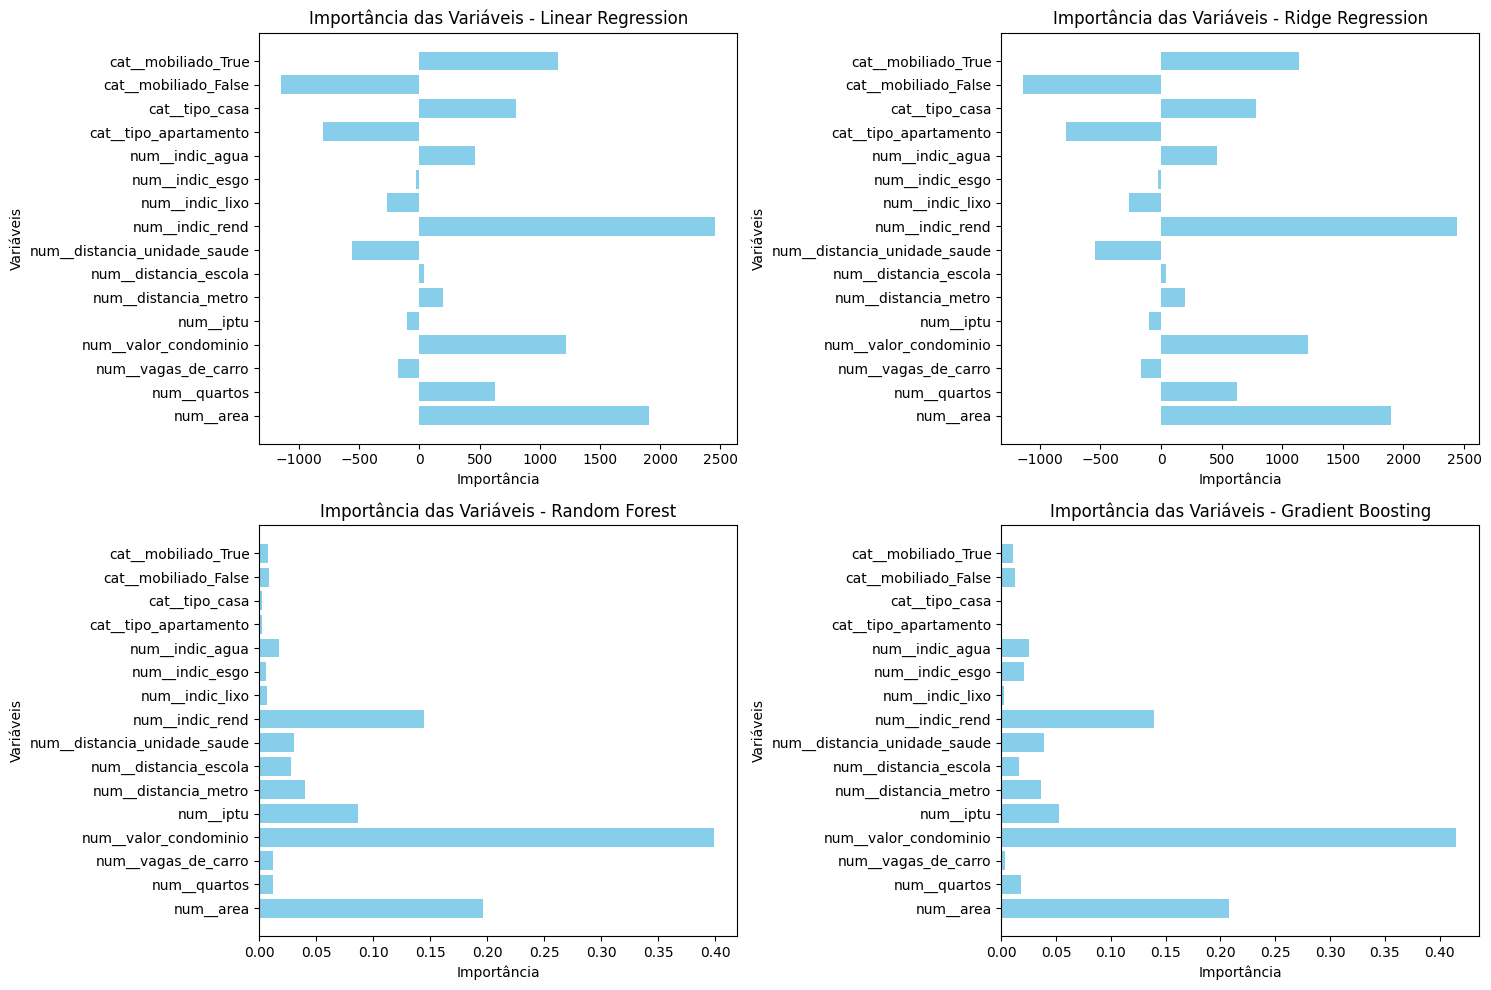

In [10]:
# Inicializar lista para armazenar importâncias
importancias_comparadas = pd.DataFrame()

# Definir o número de subgráficos
num_modelos = len(modelos)
num_colunas = 2  # 2 colunas
num_linhas = (num_modelos + 1) // num_colunas  # Calculando as linhas para acomodar os subgráficos

# Criar a figura e os subgráficos
plt.figure(figsize=(15, 5 * num_linhas))

for i, (nome, modelo) in enumerate(modelos.items()):
    plt.subplot(num_linhas, num_colunas, i + 1)
    
    modelo_treinado = modelo.fit(X_train_scaled_df, y_train)
    
    if nome in ["Linear Regression", "Ridge Regression"]:
        importancias = modelo_treinado.coef_
    elif nome in ["Random Forest", "Gradient Boosting"]:
        importancias = modelo_treinado.feature_importances_
    else:
        resultado_permutation = permutation_importance(
            modelo_treinado, X_train_scaled_df, y_train, n_repeats=10, random_state=42
        )
        importancias = resultado_permutation.importances_mean

    # Verificar alinhamento das dimensões
    if len(importancias) != len(X_train_scaled_df.columns):
        raise ValueError(
            f"Modelo {nome}: número de importâncias ({len(importancias)}) "
            f"diferente do número de colunas em X ({len(X_train_scaled_df.columns)})."
        )
    
    # Plotar a importância das variáveis
    plt.barh(X_train_scaled_df.columns, importancias, color='skyblue')
    plt.title(f'Importância das Variáveis - {nome}')
    plt.xlabel('Importância')
    plt.ylabel('Variáveis')

plt.tight_layout()
plt.show()


In [11]:
# Exibir os resultados
print("Resultados da validação cruzada com ajuste de hiperparâmetros:\n")
for nome, metricas in resultados_modelos.items():
    print(f"Modelo: {nome}")
    print(f"  Melhores Parâmetros: {metricas['Melhores Parâmetros']}")
    print(f"  MAE: {metricas['MAE']:.4f}")
    print(f"  RMSE: {metricas['RMSE']:.4f}")
    print(f"  R²: {metricas['R²']:.4f}\n")


# Resultados da validação cruzada com ajuste de hiperparâmetros:

# Modelo: Linear Regression
#   Melhores Parâmetros: Sem ajuste de hiperparâmetros
#   MAE: 2125.9978
#   RMSE: 3013.6607
#   R²: 0.7080

# Modelo: Ridge Regression
#   Melhores Parâmetros: {'model__alpha': 10.0}
#   MAE: 2099.5795
#   RMSE: 3006.8294
#   R²: 0.7094

# Modelo: Random Forest
#   Melhores Parâmetros: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}
#   MAE: 1681.7579
#   RMSE: 2716.8756
#   R²: 0.7630

# Modelo: Gradient Boosting
#   Melhores Parâmetros: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 300, 'model__subsample': 0.8}
#   MAE: 1579.1827
#   RMSE: 2609.4089
#   R²: 0.7812



Resultados da validação cruzada com ajuste de hiperparâmetros:

Modelo: Linear Regression
  Melhores Parâmetros: Sem ajuste de hiperparâmetros
  MAE: 2125.9978
  RMSE: 3013.6607
  R²: 0.7080

Modelo: Ridge Regression
  Melhores Parâmetros: {'model__alpha': 10.0}
  MAE: 2099.5795
  RMSE: 3006.8294
  R²: 0.7094

Modelo: Random Forest
  Melhores Parâmetros: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}
  MAE: 1681.7579
  RMSE: 2716.8756
  R²: 0.7630

Modelo: Gradient Boosting
  Melhores Parâmetros: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 300, 'model__subsample': 0.8}
  MAE: 1579.1827
  RMSE: 2609.4089
  R²: 0.7812

